目的：OCT2Ageモデルを開発し、年齢予測に寄与するグリッドを可視化する

# Libraries

In [1]:
import numpy as np
from numpy import linalg as LA
import pandas as pd; pd.set_option('display.max_columns', None)

import scipy as sp
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
sns.set()
%precision 3

# utility
import sys
import time
import copy as cp
from tqdm import tqdm
from collections import defaultdict
import pickle
import openpyxl as px
import xlrd
from functools import reduce

# 乱数
rng = np.random.RandomState(1234)
random_state = 42


# ローカルライブラリ
%cd /users/keimy/notebooks/OCT_hitachi
import src.archetypes as arch

/Users/keimy/notebooks/OCT_hitachi


# Check Data

In [2]:
from src.preprocess import make_datasets_in_2016

df_cpRNFL, OCT_cpRNFL = make_datasets_in_2016(filenames=["cpRNFL2016.csv"], ROI="cpRNFL")
df_mRNFL, OCT_mRNFL = make_datasets_in_2016(filenames=["mRNFL2016.csv"], ROI="mRNFL")
df_mGCLP, OCT_mGCLP = make_datasets_in_2016(filenames=["mGCLP2016.csv"], ROI="mGCLP")

dfs = [df_cpRNFL, df_mRNFL, df_mGCLP]
df = reduce(lambda left, right: pd.merge(left, right, on=["ID", "topID", "eye"]), dfs)

OCT_dfs = [OCT_cpRNFL, OCT_mRNFL, OCT_mGCLP]
OCT_df = reduce(lambda left, right: pd.merge(left, right, on=["ID", "topID", "eye"]), OCT_dfs)

df.shape, OCT_df.shape


((7666, 430), (7666, 215))

In [5]:
# kenshin = pd.read_csv("../data_kenshin/h2016.csv")
kenshin = pd.read_csv("./data_kenshin/2016R2.csv"); kenshin.drop(index=0, inplace=True)
kenshin = kenshin.rename(columns={"kenshinID": "ID" })
kenshin = kenshin.reset_index(drop=True)

# 日付型のdate変数を作成
OCT_df['date'] = pd.to_datetime(OCT_df['topID'].astype(str).str[-8:])
kenshin['date'] = pd.to_datetime(kenshin['kenshindate'].astype(str))

# IDを文字列型に変換
OCT_df['ID'] = OCT_df['ID'].astype(str)
kenshin['ID'] = kenshin['ID'].astype(str)


# IDとdateを使ってOCTとkenshinをマージ
df_comb = pd.merge(OCT_df, kenshin, on=['ID', 'date'], how='left')

# 問診項目の変数処理
def conversion_to_int(df, filling):
    df2 = pd.to_numeric(df, errors='coerce')
    df2.fillna(1, inplace=True)  # 例: 0で置換
    df2 = df2.astype(np.int64)
    return df2

df_comb["smoking"] = (conversion_to_int(df_comb["mon3x1x1"], 1) != 1).astype(int)
df_comb["drinking"] = (conversion_to_int(df_comb["mon3x2x1"], 0) != 0).astype(int)
df_comb["exercise"] = (conversion_to_int(df_comb["mon5x4x1"], 1) != 1).astype(int)

df_comb["sleep"] = conversion_to_int(df_comb["mon2x2"], 9)
df_comb["short_sleep_6"] = ((df_comb.sleep == 1) | (df_comb.sleep == 2)).astype(int)
df_comb["short_sleep_5"] = (df_comb.sleep == 1).astype(int)


len(df_comb)

/var/folders/2q/37wkg3rj6hb2r8hl9r779vgw0000gn/T/ipykernel_83803/214485458.py:2: DtypeWarning: Columns (86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,106,110,111,112,113,114,115,116,117,118,119,120,121,122,123,125,126,127,130,133,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,187,188,189,190,191,192,193,194,199,200) have mixed types. Specify dtype option on import or set low_memory=False.
  kenshin = pd.read_csv("./data_kenshin/2016R2.csv"); kenshin.drop(index=0, inplace=True)


7666

# OCT2Ageモデル

In [140]:
from src.preprocess import create_scaled_dataloader_per_CV, dataframe_to_tensor

def split_dataframe(df):
    # X_df は 'ID', 'topID', 'eye', 'date', 'age' を除くすべての列を含む
    X_df = df.drop(['ID', 'topID', 'eye', 'date', 'age'], axis=1)

    # Y_df は 'age' 列のみを含む
    Y_df = df[['age']]

    return X_df, Y_df

# OCT情報とageだけを残す
col_names = OCT_df.columns.tolist() + ["age"]
XY_df = df_comb[col_names]

# X,Yにスプリット
X_df, Y_df = split_dataframe(XY_df)

# データローダーの作成
n_splits = 2
batch_size = 64
_, _, y_train_CV, y_test_CV, train_loader_CV, test_loader_CV, scaler_age = create_scaled_dataloader_per_CV(X_df, Y_df, n_splits=n_splits, batch_size=batch_size)

In [145]:
import importlib
import src.model.OCT2Age

# モジュールの再読み込み
importlib.reload(src.model.OCT2Age)

# モジュールから必要なクラスや関数をインポート
from src.model.OCT2Age import NN_OCT2Age, train, valid


Epoch 1/5, Train Loss: 1.027036847670873, Validation Loss: 0.9292663643757503
Epoch 2/5, Train Loss: 1.009073908130328, Validation Loss: 0.9265149176120758
Epoch 3/5, Train Loss: 1.0066921263933182, Validation Loss: 0.9278150230646134
Epoch 4/5, Train Loss: 1.0075403571128845, Validation Loss: 0.9240204075972239
Epoch 5/5, Train Loss: 1.0035333742698034, Validation Loss: 0.9237094869216284


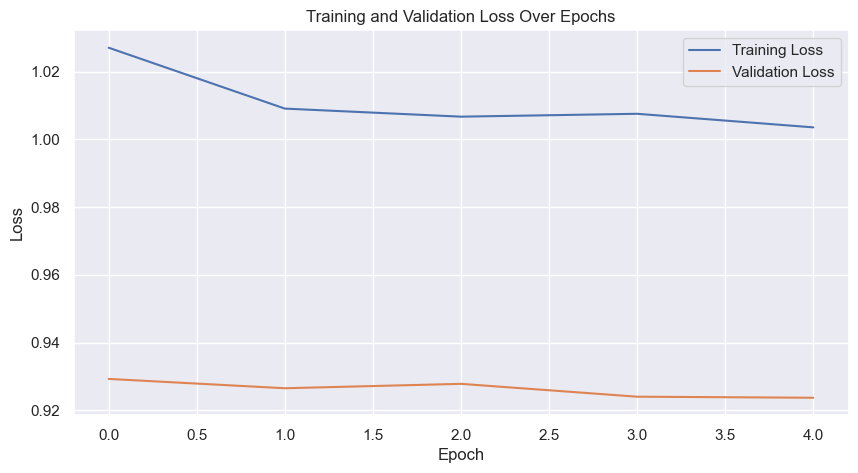

In [146]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from src.model.OCT2Age import NN_OCT2Age, train, valid


# ハイパラ
epochs = 5
dropout_rate = 0
lr = 0.001

# モデルの設定
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = "cpu"
model = NN_OCT2Age(input_dim=212, hidden_dims=[10], output_dim=1, dropout_rate=dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)


train_losses = []
val_losses = []
for epoch in range(epochs):
    # トレーニング
    train_loss = train(model, train_loader_CV[0], optimizer=optimizer, device=device)
    train_losses.append(train_loss)

    # 検証
    val_loss = valid(model, test_loader_CV[0],device=device)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

# 損失のプロット
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [ ]:
from sklearn.metrics import mean_absolute_error

Y_trues = np.array(Y_trues)
Y_preds = np.array(Y_preds)

mae = mean_absolute_error(Y_trues, Y_preds)
mse = np.mean((Y_trues - Y_preds) ** 2)
mae, mse, Y_trues.shape, Y_preds.shape

In [ ]:
df = pd.DataFrame({
    'Y_true': Y_trues,
    'Y_pred': Y_preds
})

# CSVファイルの保存パスを指定
csv_file_path = '../outputs/predictions.csv'

# DataFrameをCSVファイルに保存
df.to_csv(csv_file_path, index=False)

# 保存したCSVファイルのパスを出力
csv_file_path
